## Deep Autoencoders
code implemented from [link](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/)

### Importing required libraries and modules

In [1]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

/Users/uu/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define constants and prepare data

In [2]:
# constants
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

100%|██████████████████████████| 26421880/26421880 [00:04<00:00, 5632528.02it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 176979.03it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████| 4422102/4422102 [00:01<00:00, 2967847.50it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 2531037.04it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Utility functions

In [4]:
def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

### Define the Autoencoder Network

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


#### Define loss function and optimizer for our network

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

### Train and test functions

In [7]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    return train_loss
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

### Training Autoencoder Network

mps
Epoch 1 of 50, Train Loss: 0.075
Epoch 2 of 50, Train Loss: 0.044
Epoch 3 of 50, Train Loss: 0.037
Epoch 4 of 50, Train Loss: 0.033
Epoch 5 of 50, Train Loss: 0.030
Epoch 6 of 50, Train Loss: 0.028
Epoch 7 of 50, Train Loss: 0.027
Epoch 8 of 50, Train Loss: 0.026
Epoch 9 of 50, Train Loss: 0.025
Epoch 10 of 50, Train Loss: 0.025
Epoch 11 of 50, Train Loss: 0.024
Epoch 12 of 50, Train Loss: 0.024
Epoch 13 of 50, Train Loss: 0.024
Epoch 14 of 50, Train Loss: 0.023
Epoch 15 of 50, Train Loss: 0.023
Epoch 16 of 50, Train Loss: 0.023
Epoch 17 of 50, Train Loss: 0.022
Epoch 18 of 50, Train Loss: 0.022
Epoch 19 of 50, Train Loss: 0.021
Epoch 20 of 50, Train Loss: 0.021
Epoch 21 of 50, Train Loss: 0.021
Epoch 22 of 50, Train Loss: 0.021
Epoch 23 of 50, Train Loss: 0.021
Epoch 24 of 50, Train Loss: 0.020
Epoch 25 of 50, Train Loss: 0.020
Epoch 26 of 50, Train Loss: 0.020
Epoch 27 of 50, Train Loss: 0.020
Epoch 28 of 50, Train Loss: 0.020
Epoch 29 of 50, Train Loss: 0.019
Epoch 30 of 50, Tra

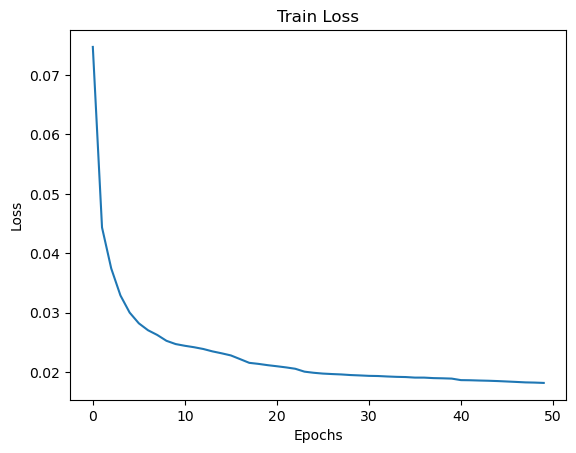

In [8]:
# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)
make_dir()
# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')
# test the network
test_image_reconstruction(net, testloader)